# Simple RNN

## Forward Propagation for RNN
$$
\begin{align}
    &a^{<t>} = g_1(W_{aa}a^{<t-1>} + W_{ax}x^{<t>} + b_a)\\
    &\hat{y} = g_2(W_{ya}a^{<t>} + b_y)
\end{align}
$$

### Simplified
$$
\begin{align}
    &a^{<t>} = g_1(W_a\big[a^{<t-1>}, x^{<t>}\big] + b_a)\\
    &\hat{y} = g_2(W_{y}a^{<t>} + b_y)
\end{align}
$$

Note that now $W_{aa}$ and $W_{ax}$ are concatenated together to form a matrix of weights rather than 2
Let's say $W_{aa}$ has the shape $(p, p)$ and $W_{ax}$ has the shape of $(p, q)$ where $q$ is the number of features for $x$. Concatenating to form the shape of $(p, p + q)$ for the matrix of newly defined $W_a$ requires us to have $[a^{<t-1>}, x^{<t>}]$ as a stacked vector with the shape of $(p + q)$, as it is the case.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Layer

2024-03-08 15:26:13.254630: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 15:26:13.292645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 15:26:13.292674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 15:26:13.293784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 15:26:13.299903: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 15:26:13.300738: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
class SimpleRNN(Layer):
    def __init__(self, units, activation='tanh', return_sequences=False, **kwargs):
        super(SimpleRNN, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        glorot_uniform = tf.initializers.glorot_uniform()
        input_dim = input_shape[-1]
        zero_dist = tf.zeros_initializer()

        self.w = self.add_weight(name='kernel_w', 
                                 shape=(self.units + input_dim, self.units),
                                 initializer=glorot_uniform,
                                 dtype='float32',
                                 trainable=True)
        self.b = self.add_weight(name='bias', 
                                 shape=(self.units,),
                                 initializer=zero_dist,
                                 dtype='float32',
                                 trainable=True)

    def call(self, input_tensors):
        x = input_tensors
        time_steps = tf.shape(x)[1]
        batch_size= tf.shape(x)[0]
        prev_state = tf.zeros(shape=(batch_size, self.units), dtype='float32')
        outputs = tf.TensorArray(dtype=tf.float32, size=time_steps)
        for t in range(time_steps):
            x_t = x[:, t, :]
            h = tf.concat([prev_state, x_t], axis=1)
            h = tf.matmul(h, self.w) + self.b
            h = self.activation(h)
            outputs = outputs.write(t, h)
            prev_state=h
        outputs = outputs.stack()
        outputs = tf.transpose(outputs, perm=[1, 0, 2])

        if not self.return_sequences:
            return outputs[:, -1, :]
        return outputs

## Define data
Here we are to create some data to train on.

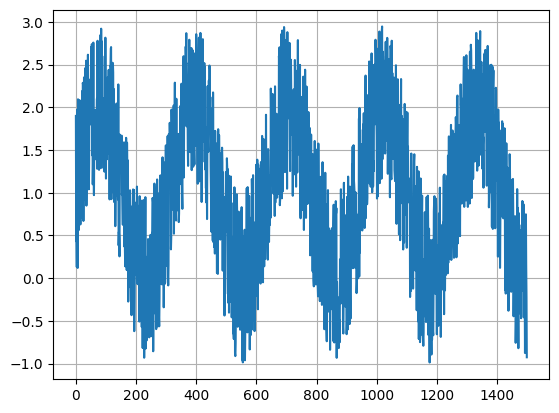

In [3]:
data = 1500 
t = np.arange(0, data)
x = np.sin(0.02 * t) + np.random.rand(data) * 2
fig, ax = plt.subplots()
ax.plot(t, x)
ax.grid()

In [4]:
def convertToDataset(data, step=3):
    X, Y = [], []
    for i in range(len(data) - step):
        d = i + step
        X.append(data[i:d])
        Y.append(data[d])
    return np.array(X, dtype='float32'), np.array(Y, dtype='float32')

## Create train/test dataset

In [5]:
validation_split = int(data * 0.8)
step = 10
X, Y = convertToDataset(x, step)
x_train = X[:validation_split]
x_test = X[validation_split:]

y_train = Y[:validation_split]
y_test = Y[validation_split:]

Shape should be
$$
    (samples, steps, features)
$$

In [6]:
x_train = np.reshape(x_train, (-1, step, 1))
x_test = np.reshape(x_test, (-1, step, 1)) 

In [7]:
print(f'x_train\'s shape is {x_train.shape}')
print(f'x_test\'s shape is {x_test.shape}')

x_train's shape is (1200, 10, 1)
x_test's shape is (290, 10, 1)


## Define the model

In [8]:
model = keras.Sequential([
    SimpleRNN(64, activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
)

In [9]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_test, y_test)
)

Epoch 1/100
75/75 [==============================] - 1s 7ms/step - loss: 0.4522 - val_loss: 0.3948
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4008 - val_loss: 0.3949
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3899 - val_loss: 0.4101
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4161 - val_loss: 0.4002
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3975 - val_loss: 0.3962
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3967 - val_loss: 0.3924
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3900 - val_loss: 0.4083
Epoch 8/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3884 - val_loss: 0.3792
Epoch 9/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3859 - val_loss: 0.3930
Epoch 10/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3782 - val_loss: 0.3768
Epoch 11/

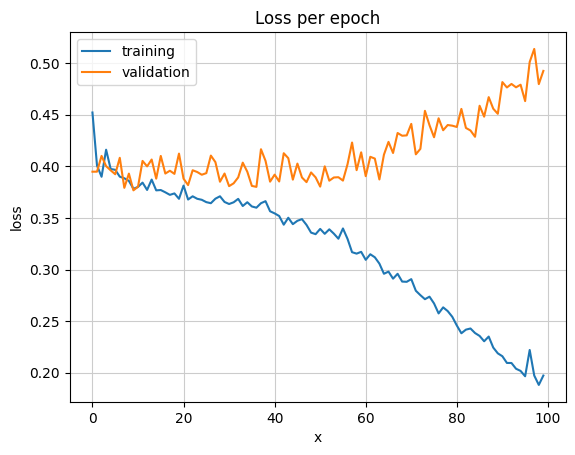

In [10]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('x')
ax.set_ylabel('loss')
ax.grid(c='#ccc')
plt.legend()

10/10 [==============================] - 0s 2ms/step


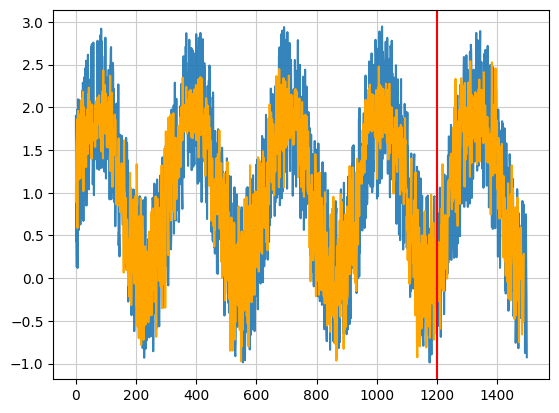

In [11]:
trainPredict = model.predict(x_train)
testPredict= model.predict(x_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.plot(x, alpha=0.9)
plt.plot(predicted, alpha=1, c='orange')
plt.axvline(len(x_train), c="r")
plt.grid(c='#ccc')
plt.show()

## With different sequence length

In [12]:
validation_split = int(data * 0.8)
train_step = 10
test_step = 20

x_train = x[:validation_split]
x_test = x[validation_split:]

In [13]:
x_train, y_train = convertToDataset(x_train, train_step)
x_test, y_test = convertToDataset(x_test, test_step)

x_train = np.reshape(x_train, (-1, train_step, 1))
x_test = np.reshape(x_test, (-1, test_step, 1)) 

print(f'x_train\'s shape is {x_train.shape}')
print(f'x_test\'s shape is {x_test.shape}')

x_train's shape is (1190, 10, 1)
x_test's shape is (280, 20, 1)


In [14]:
model = keras.Sequential([
    SimpleRNN(64, input_shape=(None, 1), activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
75/75 [==============================] - 1s 5ms/step - loss: 0.6554 - val_loss: 0.4674
Epoch 2/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4149 - val_loss: 0.4280
Epoch 3/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4023 - val_loss: 0.4011
Epoch 4/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4025 - val_loss: 0.4158
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.4000 - val_loss: 0.5455
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3800 - val_loss: 0.4446
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3893 - val_loss: 0.4148
Epoch 8/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3908 - val_loss: 0.4558
Epoch 9/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3802 - val_loss: 0.4803
Epoch 10/100
75/75 [==============================] - 0s 3ms/step - loss: 0.3895 - val_loss: 0.4820
Epoch 11/

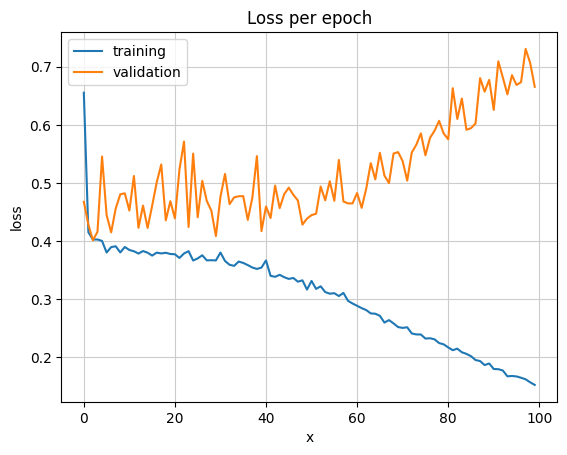

In [16]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('x')
ax.set_ylabel('loss')
ax.grid(c='#ccc')
plt.legend()

9/9 [==============================] - 0s 2ms/step


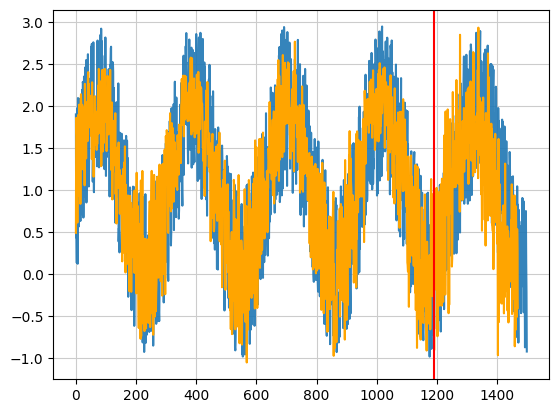

In [17]:
trainPredict = model.predict(x_train)
testPredict= model.predict(x_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.plot(x, alpha=0.9)
plt.plot(predicted, alpha=1, c='orange')
plt.axvline(len(x_train), c="r")
plt.grid(c='#ccc')
plt.show()